In [6]:
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import Descriptors


In [7]:
combined_df = pd.read_csv('../data/processed/combined_data.csv')

In [8]:
import pandas as pd
import numpy as np
from rdkit.Chem import rdChemReactions
from rdkit import DataStructs

# Function to calculate reaction fingerprint
from rdkit.Chem import rdChemReactions
from rdkit import DataStructs
import numpy as np

def calculate_reaction_fingerprint(reactant_smiles_list, product_smiles_list):
    # Create reaction SMILES
    reactant_smiles = '.'.join(reactant_smiles_list)
    product_smiles = '.'.join(product_smiles_list)
    rxn_smiles = reactant_smiles + '>>' + product_smiles
    try:
        rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles, useSmiles=True)
        if rxn is None or rxn.GetNumReactantTemplates() == 0 or rxn.GetNumProductTemplates() == 0:
            raise ValueError("Invalid reaction SMILES")
    except Exception as e:
        print(f"Error processing reaction: {rxn_smiles}\n{e}")
        # Return a zero vector of a fixed size
        return np.zeros((2048,), dtype=int)
    
    # Generate reaction fingerprint
    fingerprint = rdChemReactions.CreateDifferenceFingerprintForReaction(rxn)
    array = np.zeros((2048,), dtype=int)
    DataStructs.ConvertToNumpyArray(fingerprint, array)
    
    # Return the NumPy array containing the fingerprint data
    return array


In [9]:

# Computing reaction fingerprints
reaction_features = []

for index, row in combined_df.iterrows():
    # Get SMILES lists
    reactant_smiles_list = [row['reactant_0'], row['reactant_1']]
    product_smiles_list = [row['product_0'], row['product_1']]

    # Get reaction descriptor
    reaction_descriptor = calculate_reaction_fingerprint(reactant_smiles_list, product_smiles_list)
    reaction_features.append(reaction_descriptor)

# Convert to NumPy array
reaction_fingerprints_array = np.array(reaction_features)
print(f"Reaction fingerprints array shape: {reaction_fingerprints_array.shape}")


[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION W

Reaction fingerprints array shape: (1867, 2048)


[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION WARNING: please use AtomPairGenerator
[00:17:08] DEPRECATION W

/tmp/ipykernel_2431233/907431042.py:11: RuntimeWarning: invalid value encountered in divide
  cv_distances = std_distances / mean_distances


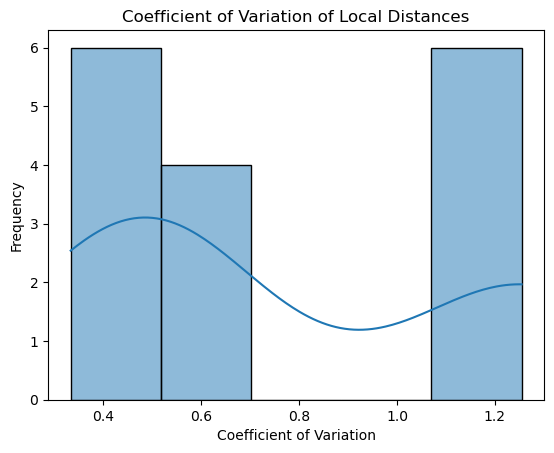

In [28]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Compute nearest neighbors
nbrs = NearestNeighbors(n_neighbors=10).fit(reaction_fingerprints_array)
distances, indices = nbrs.kneighbors(reaction_fingerprints_array)

# Calculate the coefficient of variation of distances
mean_distances = distances.mean(axis=1)
std_distances = distances.std(axis=1)
cv_distances = std_distances / mean_distances

# Plot the distribution of the coefficient of variation
plt.figure()
sns.histplot(cv_distances, kde=True)
plt.title('Coefficient of Variation of Local Distances')
plt.xlabel('Coefficient of Variation')
plt.ylabel('Frequency')
plt.show()

In [30]:
import networkx as nx

# Build the nearest neighbors graph
adjacency_matrix = nbrs.kneighbors_graph(reaction_fingerprints_array).toarray()
G = nx.from_numpy_array(adjacency_matrix)

# Check for connected components
connected_components = list(nx.connected_components(G))
num_components = len(connected_components)
print(f'Number of connected components: {num_components}')

Number of connected components: 1


/home/calvin/mambaforge/envs/umap_env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/calvin/mambaforge/envs/umap_env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


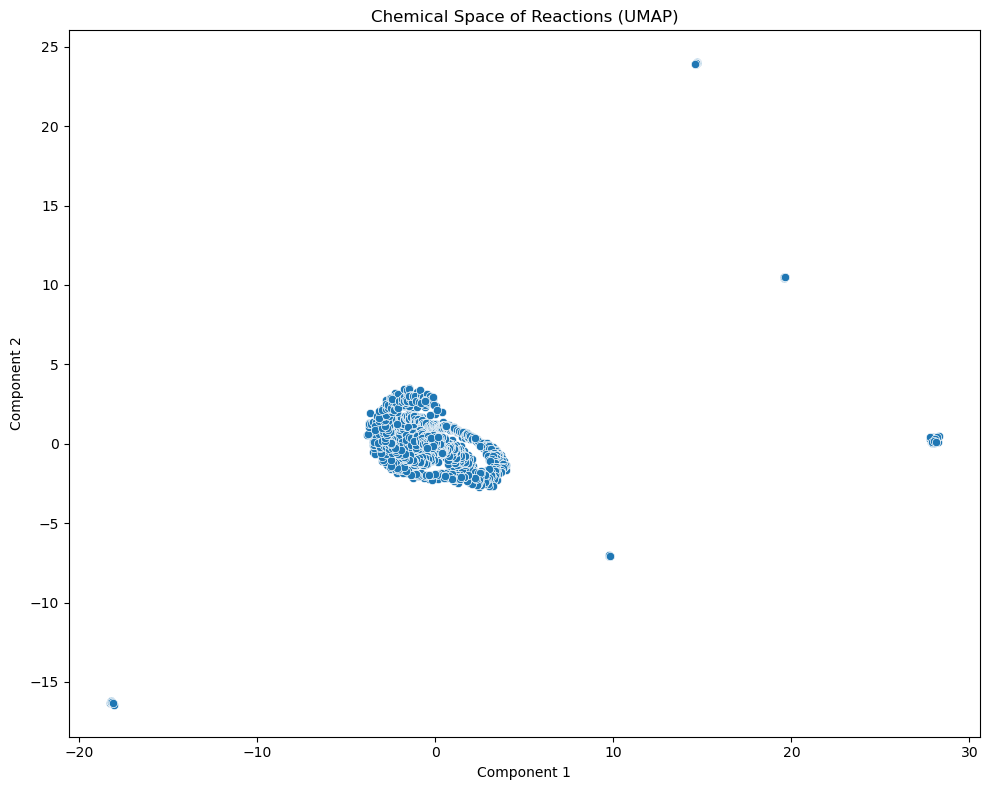

In [13]:
import umap.umap_ as umap
from matplotlib import pyplot as plt
import seaborn as sns

reducer = umap.UMAP(n_components=2, random_state=42)
umap_components = reducer.fit_transform(reaction_fingerprints_array)

# Plotting UMAP results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_components[:, 0], y=umap_components[:, 1])
plt.title('Chemical Space of Reactions (UMAP)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()

In [14]:
import numpy as np

# Calculate distances from the center (0, 0)
distances = np.sqrt(umap_components[:, 0]**2 + umap_components[:, 1]**2)

In [15]:
# Calculate the mean position
mean_x = np.mean(umap_components[:, 0])
mean_y = np.mean(umap_components[:, 1])

# Calculate distances from the mean position
distances = np.sqrt((umap_components[:, 0] - mean_x)**2 + (umap_components[:, 1] - mean_y)**2)

In [23]:
# Calculate mean and standard deviation of distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Define threshold (e.g., points more than 2 standard deviations from the mean)
threshold = mean_distance + 2 * std_distance

In [17]:
# # Define threshold as the 95th percentile
# threshold = np.percentile(distances, 95)

In [24]:
# Identify indices of outlier points
outlier_indices = np.where(distances > threshold)[0]

In [25]:
# Assuming your DataFrame is named 'combined_df'
outlier_data = combined_df.iloc[outlier_indices]

# Preview the outlier data
outlier_data

,reactant_0,reactant_1,product_0,product_1,original_reaction_id,reaction_id,source
12,CC(C)C=O,[H],C[C](C)C=O,[H][H],rxn_30,12,ZEUS
44,[N],[H][H],[NH],[H],rxn_63,44,ZEUS
46,[NH2],[H][H],N,[H],rxn_67,46,ZEUS
49,S,[H],[SH],[H][H],rxn_70,49,ZEUS
50,[H][H],[S],[SH],[H],rxn_72,50,ZEUS
...,...,...,...,...,...,...,...
1733,CCN=O,[CH2]COCC,CC=N[O],CCOCC,rmg_rxn_634,1733,ATLAS
1735,CC#N,[CH2]COCC,C=C=[N],CCOCC,rmg_rxn_638,1735,ATLAS
1761,CCN=O,[CH2]OCCC,CC=N[O],CCCOC,rmg_rxn_670,1761,ATLAS
1786,[C]#N,CCN=O,C#N,CC=N[O],rmg_rxn_746,1786,ATLAS


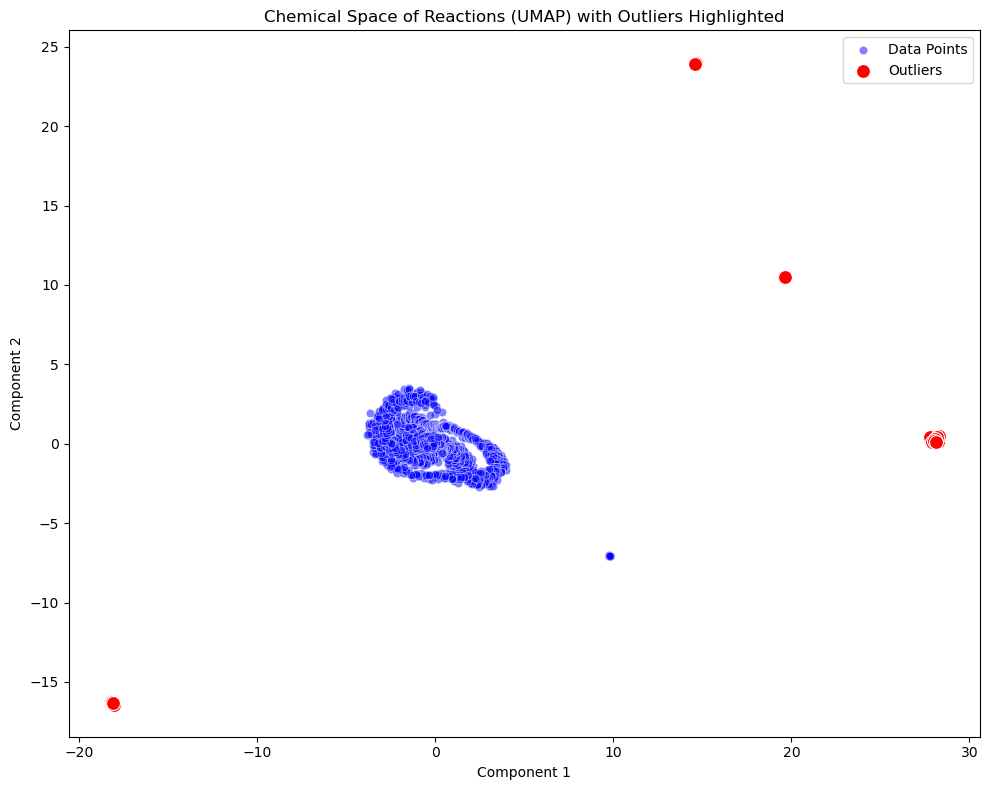

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

# Plot all points
sns.scatterplot(x=umap_components[:, 0], y=umap_components[:, 1], color='blue', alpha=0.5, label='Data Points')

# Overlay outliers
sns.scatterplot(x=umap_components[outlier_indices, 0], y=umap_components[outlier_indices, 1], color='red', s=100, label='Outliers')

plt.title('Chemical Space of Reactions (UMAP) with Outliers Highlighted')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.tight_layout()
plt.show()

[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION WARNING: please use AtomPairGenerator
[00:25:49] DEPRECATION W

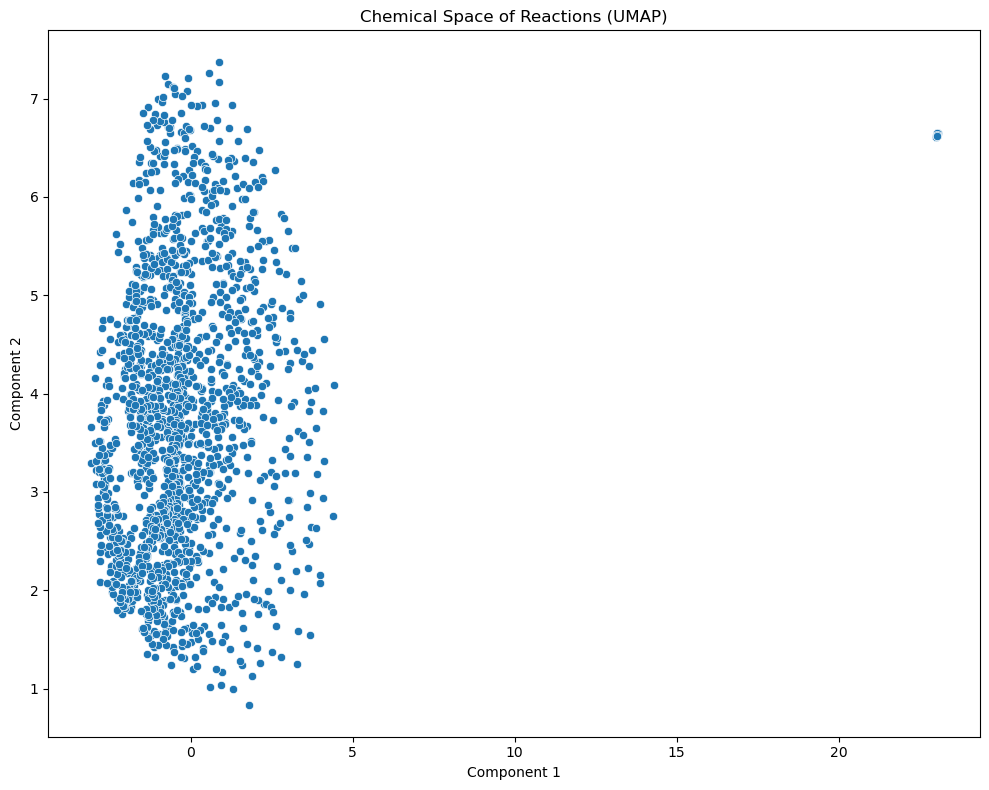

In [27]:
# Remove outlier data
combined_df = combined_df.drop(index=outlier_data.index)

# Redo the UMAP analysis
reaction_features = []

for index, row in combined_df.iterrows():
    # Get SMILES lists
    reactant_smiles_list = [row['reactant_0'], row['reactant_1']]
    product_smiles_list = [row['product_0'], row['product_1']]

    # Get reaction descriptor
    reaction_descriptor = calculate_reaction_fingerprint(reactant_smiles_list, product_smiles_list)
    reaction_features.append(reaction_descriptor)
    
# Convert to NumPy array
reaction_fingerprints_array = np.array(reaction_features)

reducer = umap.UMAP(n_components=2, random_state=42)
umap_components = reducer.fit_transform(reaction_fingerprints_array)

# Plotting UMAP results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_components[:, 0], y=umap_components[:, 1])
plt.title('Chemical Space of Reactions (UMAP)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()